refer to https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.2


In [ ]:
import pytensor as pt

# 假设 value 是 PyTensor 中的张量变量
value = pt.vector('value')  # 定义一个一维张量

# 使用 pt.expand_dims 增加新维度
value_expanded = pt.expand_dims(value, axis=1)  # 插入一个新维度到 axis=1

# 创建一个 PyTensor 函数来查看结果
expand_func = pt.function([value], value_expanded)

# 测试输出
print("PyTensor 结果：", expand_func([1, 2, 3, 4]))  # 输出形状 (4, 1)


In [75]:
def wfpt(t, v, a, w=.5, tol=1e-6):
    '''Frist passage time for Wiener diffusion model 
    
    Approximation based on Navarro & Fuss (2009).

    Args: 
        t: hit time, an array
        v: drift rate 
        a: threshold
        w: normalized starting bias
        tol: tolerence of convergence

    Outputs:
        p: probability density of the given t
    '''
    # Convert variables to PyTensor tensor variables
    t = pt.as_tensor_variable(t, dtype='float64')
    t = pt.expand_dims(t, axis=1) 
    a = pt.as_tensor_variable(a, dtype='float64')
    v = pt.as_tensor_variable(v, dtype='float64')
    w = pt.as_tensor_variable(w, dtype='float64')
    tol = pt.as_tensor_variable(tol, dtype='float64')

    # Normalized time (use pt.true_div to avoid type issues)
    t_norm = pt.true_div(t, a**2)

    # calculate the number of terms needed for large time
    if pm.math.gt(np.pi*t_norm*tol, 1):
        kl = np.sqrt(-2*np.log(np.pi*t_norm*tol) / (np.pi**2*t_norm))
        kl = pm.math.max([kl, 1/(np.pi*np.sqrt(t_norm))])
    else:
        kl = 1/(np.pi*np.sqrt(t_norm))
    
    # calculate number of terms needed for small time 

    if pm.math.gt(2*np.sqrt(2*np.pi*t_norm)*tol, 1):
        ks = 2+np.sqrt(-2*t_norm*np.log(2*np.sqrt(2*np.pi*t_norm)*tol))
        ks = pm.math.max([ks, np.sqrt(t_norm)+1])
    else:
        ks = 2 # minimal kappa for the case
    # compute f(t_norm|0,1,w)
    if pm.math.gt(ks, kl):
        K = np.ceil(ks)
        k = pt.arange(-pt.floor((K-1)/2), pt.ceil((K-1)/2)+1)
        p = ((w+2*k)*np.exp(-((w+2*k)**2)/2/t_norm)).sum()/\
            np.sqrt(2*np.pi*t_norm**3)
    else:
        K = pt.ceil(kl)
        k = pt.arange(1, K+1)
        p = (k*np.exp(-(k**2)*(np.pi**2)*t_norm/2)*
                np.sin(k*np.pi*w)).sum()*np.pi
    # convert to f(t|v,a,w)
    P = (p*np.exp(-v*a*w - (v**2)*t/2) / (a**2))
    print(P)
    return P

In [76]:
%%time
t = np.random.uniform(0, 5, 1000)
def logwfpt(t, v, a, w):
    return np.log(wfpt(t, v, a, w))+(1e-10)
with pm.Model() as model:
    v=  pm.HalfNormal("v", sigma=3)
    a = pm.HalfNormal("a", sigma=1)
    w = pm.Uniform("w", lower=0.1, upper=0.9)
    ddm = pm.DensityDist("wfpt", 
                            v,
                            a,
                            w,
                            logp=logwfpt, 
                            observed=t)
    trace = pm.sample(2000, tune=1000, cores=1,chains=1)

True_div.0
True_div.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


True_div.0
True_div.0
True_div.0


Sequential sampling (1 chains in 1 job)
NUTS: [v, a, w]


Output()

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 8.23 s, sys: 1.68 s, total: 9.91 s
Wall time: 19.8 s


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

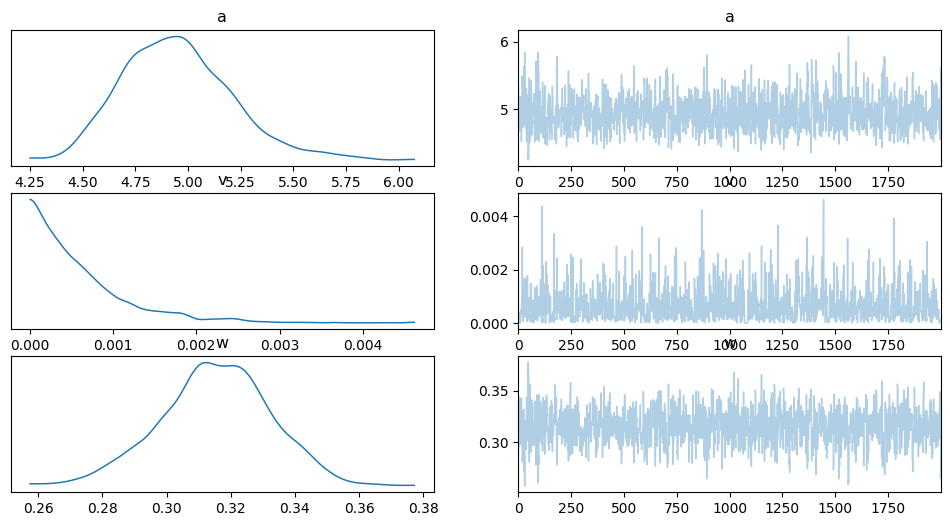

In [77]:
az.plot_trace(trace)